# **Problem Set 04 - Networks**

## Group Members:
1. **Maria Aleman**  
   <maria.aleman@bse.eu>

2. **Marta Sala**  
   <marta.sala@bse.eu>

3. **Elena Ryan**  
   <elena.ryan@bse.eu>

4. **Enzo Infantes**  
   <enzo.infantes@bse.eu>


<img src='https://upload.wikimedia.org/wikipedia/commons/4/41/BSE_primary_logo_color.jpg' width=300 />

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import openmatrix as omx
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy.optimize as opt
from joblib import Parallel, delayed

# **1. Loading Data**

In [2]:
root = r"c:\\Users\\Enzo\\Documents\\BSE\\T2\\NETWORK\\PS4\\networks_roads\\"

netfile = os.path.join(root, 'Barcelona','Barcelona_net.tntp')
net = pd.read_csv(netfile, skiprows=8, sep='\t')

trimmed= [s.strip().lower() for s in net.columns]
net.columns = trimmed

# And drop the silly first andlast columns
net.drop(['~', ';'], axis=1, inplace=True)

In [3]:
net.head()

,init_node,term_node,capacity,length,free_flow_time,b,power,speed,toll,link_type
0,1,290,1,1.083333,1.083333,0.0,0.0,0,0,9
1,1,307,1,1.083333,1.083333,0.0,0.0,0,0,9
2,1,316,1,1.083333,1.083333,0.0,0.0,0,0,9
3,2,302,1,1.666667,1.666667,0.0,0.0,0,0,9
4,2,304,1,1.666667,1.666667,0.0,0.0,0,0,9


In [4]:
net.describe()

,init_node,term_node,capacity,length,free_flow_time,b,power,speed,toll,link_type
count,2522.000000,2522.000000,2522.0,2522.000000,2522.000000,2.522000e+03,2522.000000,2522.0,2522.0,2522.000000
mean,552.013481,553.138779,1.0,0.645347,0.645347,8.789544e-12,4.245316,0.0,0.0,2.792228
std,292.815176,292.902726,0.0,1.650823,1.650823,1.029939e-10,3.607161,0.0,0.0,3.336189
min,1.000000,1.000000,1.0,0.051429,0.051429,0.000000e+00,0.000000,0.0,0.0,1.000000
25%,313.000000,313.250000,1.0,0.188571,0.188571,1.967150e-67,4.217250,0.0,0.0,1.000000
50%,560.000000,562.000000,1.0,0.373333,0.373333,1.087306e-18,4.446000,0.0,0.0,1.000000
75%,821.000000,822.000000,1.0,0.778333,0.778333,7.010272e-18,4.924000,0.0,0.0,1.000000
max,1020.000000,1020.000000,1.0,55.000000,55.000000,2.176649e-09,16.830000,0.0,0.0,9.000000


# **2. Solving Question 4**

The paper (Youn et al., 2008) assumes a latency function given by:


$$
\text{latency} = \frac{d_{ij}}{v_{ij}} \times \left[ 1 + \alpha \left( \frac{x_{ij}}{p_{ij}} \right)^{\beta} \right]
$$

Where $d_{ij}$ is the distance of the link between $i$ and $j$; $v_{ij}$ the speed limit (assume 60 kph on all links for simplicity), $x_{ij}$ the flow, and $p_{ij}$ the capacity of the road segment. The parameters $\alpha$ and $\beta$ have been fitted to empirical data as $\alpha = 0.2$ and $\beta = 10$.

**2.a. Latency and Plot**: You will see that the data contains all the information needed to compute the latency above. Import the data and plot your network.

In [5]:
df = net.copy()

df.rename(columns={"length": "d_ij", "capacity": "p_ij"}, inplace=True)

# Define some parameters
alpha = 0.2  
beta = 10    
v_ij = 60 

# Estimate traffic flow (x_ij) as the proportional to its capacity and its normalized free flow time (assumption)
df["x_ij"] = df["p_ij"] * (df["free_flow_time"] / df["free_flow_time"].max())

# Compute Latency
df["latency"] = (df["d_ij"] / v_ij) * (1 + alpha * (df["x_ij"] / df["p_ij"]) ** beta)

# Create a directed graph
G = nx.DiGraph()

for _, row in df.iterrows():
    G.add_edge(row["init_node"], row["term_node"], length=row["latency"])

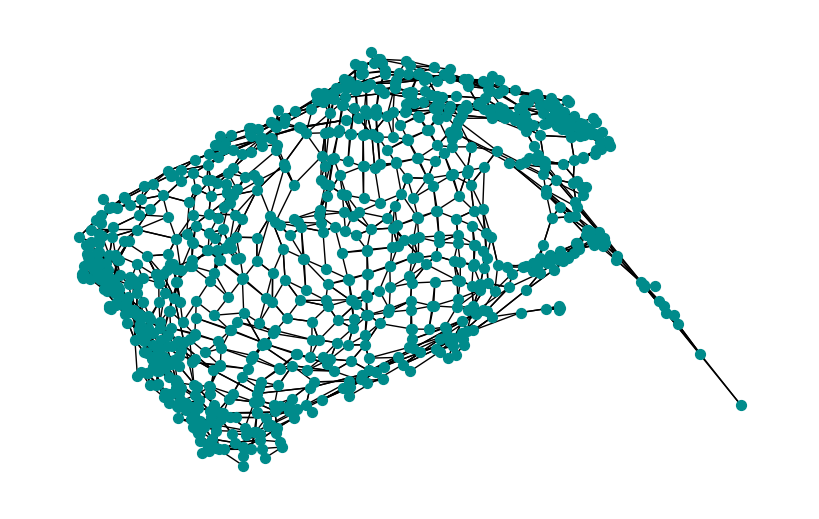

In [7]:
plt.figure(figsize=(8, 5))

pos = nx.spring_layout(G, k=0.1, iterations=250, scale=8) 
nx.draw(G, pos, with_labels=False, node_size=50, node_color="darkcyan", edge_color="black", font_size=8, arrows=False)
edge_labels = {(u, v): f"{d['length']:.2f}" for u, v, d in G.edges(data=True)} # they dont look good on the graph
nx.draw_networkx_edge_labels(G, pos, edge_labels=False, font_size=8)

plt.show()

**2.b. Equilibrium**: Compute the equilibrium (i.e. Nash) flow of your network by minimizing the *potential function* that we saw in class.

---

For this question, we are considering the following expression as the **potential function**:

$$
\Phi(x) = \sum_{(i,j) \in E} \int_{0}^{x_{ij}} l_{ij}(t) \, dt
$$

where $l_{ij}(t)$ is the latency function as we saw above.

Expanding the previous expression:

$$
\Phi(x) = \sum_{(i,j) \in E} \int_{0}^{x_{ij}} \frac{d_{ij}}{v_{ij}} \left( 1 + \alpha \left( \frac{t}{p_{ij}} \right)^{\beta} \right) \, dt
$$

By computing the integral, we can obtain the final expression for this analysis:

$$
\Phi(x) = \sum_{(i,j) \in E} \frac{d_{ij}}{v_{ij}} \left[ x_{ij} + \frac{\alpha x_{ij}^{\beta + 1}}{(\beta + 1) p_{ij}^{\beta}} \right]
$$


According to the instructions, we are using a random sample from the data. This is useful to avoid high computational costs for the following questions.

In [63]:
df_sample = df.sample(n=30, random_state=42) 

In [64]:
# Define potential function
def potential_function(x, d_ij, p_ij, v_ij, alpha, beta):
    """
    Compute the potential function for the traffic network.
    x: Array of flow values
    d_ij: Distances between nodes
    p_ij: Capacities of edges
    v_ij: Vehicle speed
    alpha, beta: Parameters controlling the latency
    """
    return np.sum((d_ij / v_ij) * (x + alpha * (x ** (beta + 1)) / ((beta + 1) * p_ij ** beta)))

In [65]:
# Initial guess: start with half the capacity (assumption)
x0 = df_sample["p_ij"] * 0.5

# Bounds: Flow must be between 0 and the capacity for each link
bounds = [(0, cap) for cap in df_sample["p_ij"]]

# Optimize the potential function to find the Nash equilibrium
result = opt.minimize(lambda x: potential_function(x, df_sample["d_ij"].values, df_sample["p_ij"].values, v_ij=60, alpha =0.2, beta=10),
                      x0, 
                      bounds=bounds,
                      method='trust-constr'  # robust optimization method    
                     )


df_sample["x_ij_eq"] = result.x
print("Optimized Nash Equilibrium Flows:")
print(df_sample[["init_node", "term_node", "x_ij_eq"]])
print(f'Aggregate Equilibrium: {round(df_sample["x_ij_eq"].sum(),5)}\n Mean of Equilibrium Flows: {round(df_sample["x_ij_eq"].mean(),5)}')

Optimized Nash Equilibrium Flows:
      init_node  term_node   x_ij_eq
196          68       1003  0.000438
986         454        455  0.001929
1090        493        494  0.002536
387         239        576  0.002536
2222        925       1013  0.000180
168          58        627  0.000732
1378        612        611  0.003148
2464       1002        980  0.000503
705         333        332  0.000458
2076        879        874  0.000458
1848        803        816  0.001998
1411        625        629  0.000504
430         255        253  0.000795
2148        901        906  0.000753
2494       1009        250  0.000082
1619        702         51  0.000518
861         397        372  0.002536
282         110        999  0.000521
1513        658        756  0.000033
649         319        317  0.000983
1075        488        436  0.001792
1355        602        603  0.002846
1382        614        616  0.001686
1087        492        496  0.001927
2143        900        902  0.000191
1216

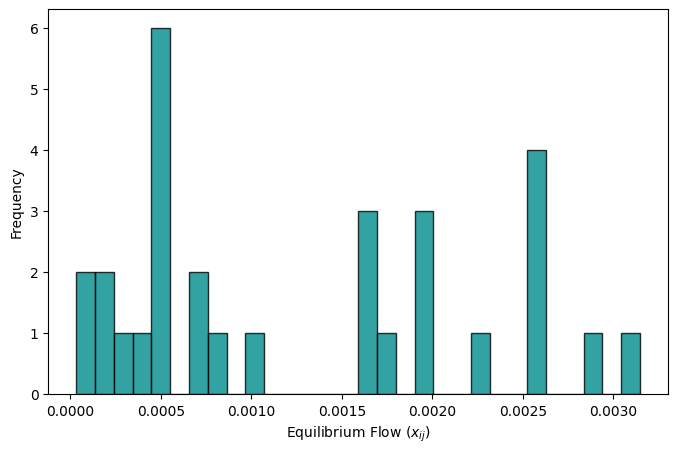

In [66]:
plt.figure(figsize=(8, 5))

plt.hist(df_sample["x_ij_eq"], bins=30, color='darkcyan', edgecolor='black', alpha=0.8)
#plt.title("Distribution of Equilibrium Flows", fontsize=16)
plt.xlabel("Equilibrium Flow ($x_{ij}$)", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.show()

In [67]:
original_cost = (df_sample["latency"] * df_sample["x_ij_eq"]).sum()

print(f"Original Total Latency Cost: {original_cost}")

Original Total Latency Cost: 0.00017859333206484156


**2.c. Cost and Closing** Compare the costs of the Nash flow on the original network with those on networks where one of the streets is closed to traffic. Repeat this by closing each street (one at a time).

In [72]:
def compute_modified_costs(df, potential_function, v_ij=60, alpha=0.2, beta=10):
    """
    This function calculates the total cost when a specific street is closed.
    It uses the same optimization method (trust-constr) for this part.
    We will obtain the total cost for each closed street.
    """
    modified_costs = []
    original_cost = (df["latency"] * df["x_ij_eq"]).sum()
    
    for index, row in df.iterrows():
        modified_df = df.copy()
        
        # Close one street (one at time)
        modified_df.at[index, "p_ij"] = 0  
        
        # Settings for the optimization
        x0 = modified_df["p_ij"] * 0.5
        bounds = [(0, cap) for cap in modified_df["p_ij"]]
        v_ij_array = np.full(len(modified_df), v_ij)
        
        # Optimization process
        result = opt.minimize(
            lambda x: potential_function(x, modified_df["d_ij"].values, modified_df["p_ij"].values, 
                                         v_ij_array, alpha, beta),
            x0, 
            bounds=bounds,
            method='trust-constr'
        )
        
        modified_df["x_ij_eq"] = result.x
        modified_cost = (modified_df["latency"] * modified_df["x_ij_eq"]).sum()
        
        cost_difference = modified_cost - original_cost
        
        modified_costs.append((index, modified_cost, cost_difference))
    
    return pd.DataFrame(modified_costs, columns=["Closed Street", "New Cost", "Cost Difference"])


In [73]:
df_results = compute_modified_costs(df_sample, potential_function)
df_results.head()

C:\Users\Enzo\AppData\Local\Temp\ipykernel_13080\2604705675.py:11: RuntimeWarning: invalid value encountered in divide
  return np.sum((d_ij / v_ij) * (x + alpha * (x ** (beta + 1)) / ((beta + 1) * p_ij ** beta)))
C:\Users\Enzo\AppData\Local\Temp\ipykernel_13080\2604705675.py:11: RuntimeWarning: divide by zero encountered in divide
  return np.sum((d_ij / v_ij) * (x + alpha * (x ** (beta + 1)) / ((beta + 1) * p_ij ** beta)))


,Closed Street,New Cost,Cost Difference
0,196,0.232886,0.232708
1,986,0.238903,0.238725
2,1090,0.239359,0.239180
3,387,0.239359,0.239180
4,2222,0.236803,0.236625


**4.d. Final Results**: Can you find street(s) where closing it decreased the cost of the Nash flow? If you did, you have found one of the black streets in the figure above. You may now call the mayor and let her know the good news.

In [87]:
df_results[df_results['Cost Difference']<0].sum()

Closed Street      0.0
New Cost           0.0
Cost Difference    0.0
dtype: float64

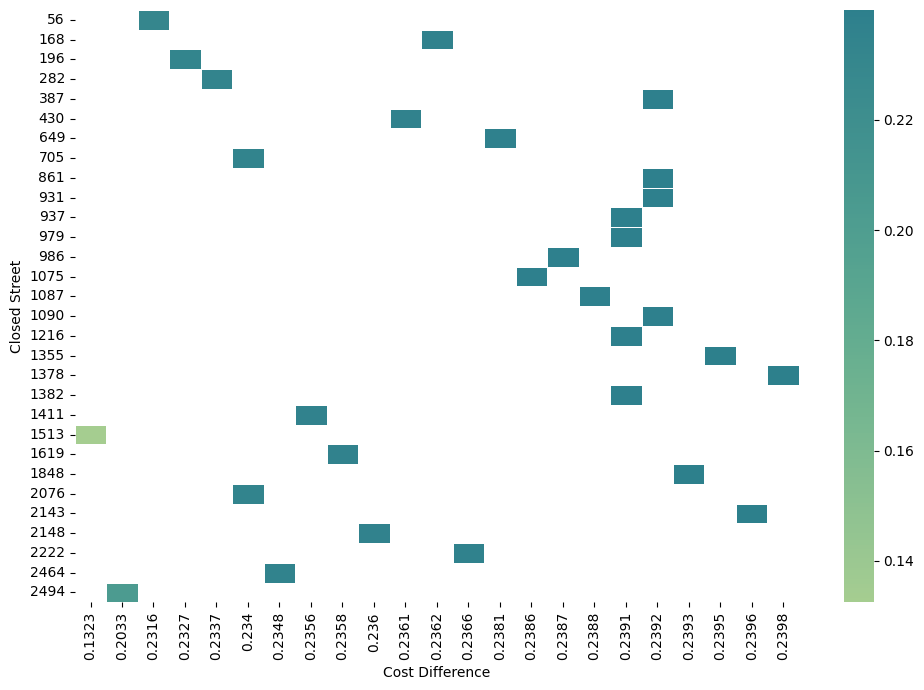

In [113]:
df_sorted = df_results.sort_values(by="Cost Difference", ascending=False)
df_sorted = df_sorted.round(4)

heatmap_data = df_sorted.pivot(index="Closed Street", columns="Cost Difference", values="New Cost")

plt.figure(figsize=(10, 7))
sns.heatmap(heatmap_data, annot=False, cmap="crest", linewidths=0.5, fmt=".4f", center=df_results["New Cost"].mean())
plt.xlabel("Cost Difference", fontsize=10)
plt.ylabel("Closed Street", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.show()